# KGAT-Attention 模型推理與解釋 (含名稱映射)

這個 Notebook 展示如何載入訓練好的 **KGAT-Attention** 模型，並將推薦路徑中的編號轉換為真實的**食譜名稱**、**成份**或**標籤**。

In [4]:
import os
import sys
import torch
import argparse
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 確保能抓到專案根目錄
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 允許載入 argparse.Namespace (PyTorch 2.6+ 安全性要求)
if hasattr(torch.serialization, 'add_safe_globals'):
    torch.serialization.add_safe_globals([argparse.Namespace])

from src.model.kgat_attention import KGATAttention
from src.model.explainer_attention import KGATAttentionExplainer
from src.train_att import load_data, get_adj_indices

## 1. 載入資料、模型與名稱映射

In [5]:
# 設定 Device
if hasattr(torch, 'xpu') and torch.xpu.is_available():
    device = torch.device('xpu')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

data_dir = '../data/processed'
interactions, kg_triples, stats = load_data(data_dir)

n_users = stats['n_users']
n_items = stats['n_items']
n_entities = stats['n_entities']
n_relations = stats['n_relations']

# --- 建立名稱映射 ---
print("正從原始 CSV 載入名稱映射 (這可能需要幾秒鐘)...")
df_raw_recipes = pd.read_csv('../data/raw/RAW_recipes.csv')
recipe_id_to_name = dict(zip(df_raw_recipes['id'], df_raw_recipes['name']))

# 建立 Entity ID (remapped) 到名稱的映射
inv_ingredient_map = {v: k for k, v in stats['ingredient_map'].items()}
inv_tag_map = {v: k for k, v in stats['tag_map'].items()}
entity_id_to_name = {**inv_ingredient_map, **inv_tag_map}

def get_node_name(node_id):
    if node_id < n_users:
        # User: 顯示原始 User ID
        original_user_id = stats['user_map'].inverse_transform([node_id])[0]
        return f"User({original_user_id})"
    elif node_id < n_users + n_items:
        # Item (Recipe): 轉換回原始 ID 再查表找名稱
        remapped_item_id = node_id - n_users
        original_item_id = stats['item_map'].inverse_transform([remapped_item_id])[0]
        return recipe_id_to_name.get(original_item_id, f"Recipe({original_item_id})")
    else:
        # Entity (Ingredient/Tag): 直接從 map 找名稱
        remapped_entity_id = node_id - n_users - n_items
        return entity_id_to_name.get(remapped_entity_id, f"Entity({remapped_entity_id})")

print("名稱映射建立完成。")

# --- 初始化模型 ---
indices, num_nodes = get_adj_indices(kg_triples, interactions, n_users, n_items, n_entities)
indices = indices.to(device)

model_path = '../models/kgat_att_local_ckpt_e20.pth'
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    embed_dim = getattr(checkpoint['args'], 'embed_dim', 32) if 'args' in checkpoint else 32
    layers = getattr(checkpoint['args'], 'layers', [32]) if 'args' in checkpoint else [32]
    
    model = KGATAttention(n_users, n_items + n_entities, n_relations, embed_dim=embed_dim, layers=layers).to(device)
    model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
    print("Model loaded successfully!")
else:
    print("Warning: Checkpoint not found.")
    model = KGATAttention(n_users, n_items + n_entities, n_relations).to(device)

model.eval()

Using device: xpu
Loading data from ../data/processed...
正從原始 CSV 載入名稱映射 (這可能需要幾秒鐘)...
名稱映射建立完成。
Constructing graph indices with interactions...
Model loaded successfully!


KGATAttention(
  (user_embed): Embedding(226570, 32)
  (entity_embed): Embedding(247131, 32)
  (relation_embed): Embedding(2, 32)
  (aggregator_layers): ModuleList(
    (0): GNNLayerAttention(
      (W1): Linear(in_features=32, out_features=32, bias=True)
      (W2): Linear(in_features=32, out_features=32, bias=True)
      (W_att): Linear(in_features=32, out_features=32, bias=True)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)

## 2. 執行解釋與視覺化 (顯示真實名稱)

Target User: User(1755), Target Item: sausage gravy
Prediction Score: 3.4087

Top Explanation Paths (Attention based):
 User(1755) -> sausage gravy (Score: 0.333672)
 User(1755) -> jamaican golden split pea soup -> dietary -> sausage gravy (Score: 0.000047)
 User(1755) -> jamaican golden split pea soup -> easy -> sausage gravy (Score: 0.000047)
 User(1755) -> jamaican golden split pea soup -> preparation -> sausage gravy (Score: 0.000047)
 User(1755) -> jamaican golden split pea soup -> course -> sausage gravy (Score: 0.000047)


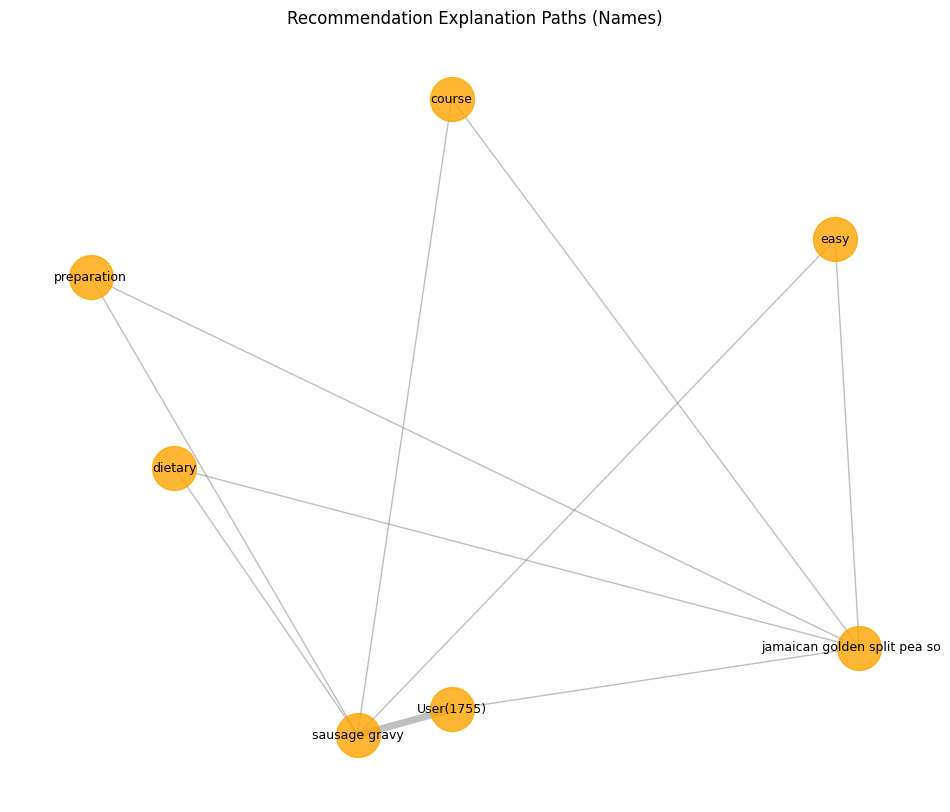

In [6]:
target_user = 5
user_interactions = interactions[interactions[:, 0] == target_user]

if len(user_interactions) > 0:
    target_item = int(user_interactions[0][1])
    target_item_name = get_node_name(target_user + target_item + n_users - target_user) # 修正偏移邏輯
    target_item_name = get_node_name(n_users + target_item)
    print(f"Target User: {get_node_name(target_user)}, Target Item: {target_item_name}")
    
    explainer = KGATAttentionExplainer(model)
    explanation = explainer.explain(indices, num_nodes, target_user, target_item, top_k=5, n_hops=2)
    
    if explanation:
        print(f"Prediction Score: {explanation['target_score']:.4f}")
        print("\nTop Explanation Paths (Attention based):")
        for path, score in explanation['top_paths']:
            path_names = [get_node_name(node_id) for node_id in path]
            print(f" {' -> '.join(path_names)} (Score: {score:.6f})")
            
        # 視覺化子圖
        # 注意：視覺化時標籤也會嘗試使用真實名稱
        graph = explanation['subgraph']
        labels = {node: get_node_name(node) for node in graph.nodes()}
        
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(graph)
        nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color="orange", alpha=0.8)
        nx.draw_networkx_labels(graph, pos, labels=labels, font_size=9)
        
        # 邊線粗細代表權重
        weights = [graph[u][v]['weight'] for u, v in graph.edges()]
        if weights:
            max_w, min_w = max(weights), min(weights)
            widths = [(w - min_w)/(max_w - min_w + 1e-9) * 4 + 1 for w in weights]
            nx.draw_networkx_edges(graph, pos, width=widths, edge_color="gray", alpha=0.5)
            
        plt.title("KGAT Explanation (Attention-based)")
        plt.axis('off')
        plt.show()
else:
    print(f"User {target_user} has no interactions.")